In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import sys
sys.path.insert(0,'../')

In [2]:
from src.mlflow_utils import mlflow, get_run_list, download_run_data
from src.ha_utils import set_sensor_state, Input
from src.genai_evaluation import async_prompting, generate_prompt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Non-GenAI Scores

In [ ]:
# a71e5cfb0a954f63b17c3c7b3c626e64 --> 0.5247959426263278
# 71254e7e5ced4ce2a27c5de31f7fb7ab --> 0.5241627966732723
# e1d3f1f8aace43caa693e9836834504e --> 
# cb8135f768dd4a8285257deb0bc3d912 --> 0.5240697396879908
# 5565790ff7c74ef69997fc0af6a3cd06 --> 0.5254168598952033
# 41ef3452981a4b208aa35c8f8b7197df --> 0.5104922168193816
# 14ae3307f7df4c26b249b847ef24c26a --> 0.5018933512907802
# ebee22c9aef14c8baaca0ec3192e8833 --> 0.5103564892456643
# 9eaf7a3028bd4b2cb773d0105f165add --> 0.5231842858875173
# 7e5d6c8cba4d49a8853e5e4c06072da7 --> 0.5239859657285223

## Scoring

In [4]:
from src.evaluation import create_bertscore, create_moverscore, create_rougescore

In [10]:
from src.evaluation import create_aigen_similarity

/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
def prompt_default(context_example, context_word, prediction, ground_truth):
    return f"""
Aufgabe:

Sie müssen die folgenden Felder in Ihrer Antwort in zwei Zeilen untereinander angeben:
Punktzahl: Ihre numerische Punktzahl für die Antwort_Ähnlichkeit des Modells basierend auf der Rubrik
Begründung: Ihre Begründung für die Bewertung der Antwort_Ähnlichkeit des Modells

Sie sind ein unparteiischer Richter. Sie erhalten eine Eingabe, die an ein maschinelles Lernmodell gesendet wurde, und Sie erhalten eine Ausgabe, die das Modell erzeugt hat. Möglicherweise erhalten Sie auch zusätzliche Informationen, die vom Modell verwendet wurden, um die Ausgabe zu erzeugen.

Ihre Aufgabe besteht darin, auf der Grundlage der Eingabe und der Ausgabe einen numerischen Wert namens answer_similarity zu bestimmen. Im Folgenden finden Sie eine Definition von answer_similarity und eine Bewertungsrubrik. Sie müssen die Bewertungsrubrik verwenden, um Ihre Punktzahl zu ermitteln. Außerdem müssen Sie Ihre Punktzahl begründen.

Zur Veranschaulichung können unten Beispiele angeführt werden. Stellen Sie sicher, dass Sie diese als Referenz verwenden und sie verstehen, bevor Sie die Aufgabe lösen.

Ausgabe:
{prediction}

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:

{ground_truth}


Definition der Metrik:

Die Antwortähnlichkeit wird anhand des Grades der semantischen Ähnlichkeit zwischen der bereitgestellten Ausgabe und den bereitgestellten Zielen, d. h. der Grundwahrheit, bewertet. Punkte können auf der Grundlage der schrittweisen Ähnlichkeit in Bedeutung und Beschreibung mit den vorgegebenen Zielen vergeben werden, wobei eine höhere Punktzahl eine größere Übereinstimmung zwischen der bereitgestellten Ausgabe und den vorgegebenen Zielen anzeigt.


Benotungsrubrik:

Ähnlichkeit der Antwort: Nachfolgend finden Sie die Details für die verschiedenen Bewertungsstufen:

- Punktzahl 1: Die Ausgabe weist wenig bis keine semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 2: Die Ausgabe weist in einigen Aspekten eine teilweise semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 3: Die Ausgabe weist eine mäßige semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 4: Die Ausgabe stimmt in den meisten Aspekten mit den vorgegebenen Zielen überein und weist eine große semantische Ähnlichkeit auf.
- Punktzahl 5: Die Ausgabe stimmt in allen wesentlichen Aspekten mit den vorgegebenen Zielen überein.


Beispiele:

Beispiel Output:
MLflow ist eine Open-Source-Plattform.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
MLflow ist eine Open-Source-Plattform für die Verwaltung des gesamten Lebenszyklus von maschinellem Lernen (ML). Sie wurde von Databricks entwickelt, einem Unternehmen, das sich auf Lösungen für Big Data und maschinelles Lernen spezialisiert hat. MLflow wurde entwickelt, um die Herausforderungen zu bewältigen, denen sich Datenwissenschaftler und Ingenieure für maschinelles Lernen bei der Entwicklung, dem Training und dem Einsatz von Modellen für maschinelles Lernen gegenübersehen.


Beispiel Punktzahl: 2
Beispiel Begründung: Die bereitgestellte Ausgabe ist dem Ziel teilweise ähnlich, da sie die allgemeine Idee, dass MLflow eine Open-Source-Plattform ist, erfasst. Es fehlen jedoch die umfassenden Details und der Kontext, die in der Zielvorgabe über den Zweck von MLflow, seine Entwicklung und die Herausforderungen, die es angeht, enthalten sind. Daher weist sie zwar eine teilweise, aber keine vollständige semantische Ähnlichkeit auf.


Beispiel Ausgabe:
MLflow ist eine Open-Source-Plattform für die Verwaltung von Arbeitsabläufen des maschinellen Lernens, einschließlich der Verfolgung von Experimenten, der Paketierung von Modellen, der Versionierung und der Bereitstellung, wodurch der Lebenszyklus von ML vereinfacht wird.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
MLflow ist eine Open-Source-Plattform für die Verwaltung des gesamten Lebenszyklus von maschinellem Lernen (ML). Sie wurde von Databricks entwickelt, einem Unternehmen, das sich auf Lösungen für Big Data und maschinelles Lernen spezialisiert hat. MLflow wurde entwickelt, um die Herausforderungen zu bewältigen, mit denen Datenwissenschaftler und Ingenieure für maschinelles Lernen bei der Entwicklung, dem Training und dem Einsatz von Modellen für maschinelles Lernen konfrontiert sind.

Beispiel Punktzahl: 4
Beispiel Begründung: Der bereitgestellte Output ist eng mit dem Ziel verbunden. Sie deckt verschiedene Schlüsselaspekte ab, die in der Zielvorgabe erwähnt werden, einschließlich der Verwaltung von Workflows für maschinelles Lernen, der Verfolgung von Experimenten, der Modellpaketierung, der Versionierung und der Bereitstellung. Auch wenn sie nicht jedes einzelne Detail der Zielvorgabe enthält, weist sie eine erhebliche semantische Ähnlichkeit auf.


Sie müssen die folgenden Felder in Ihrer Antwort in zwei Zeilen angeben, eine unter der anderen:
Punktzahl: Ihre numerische Punktzahl für die Antwortähnlichkeit des Modells auf der Grundlage der Rubrik
Begründung: Ihre Begründung für die Bewertung der Antwort_Ähnlichkeit des Modells

Fügen Sie keine weiteren neuen Zeilen hinzu. Fügen Sie keine weiteren Felder hinzu.


Lösung:"""

In [4]:
def prompt_1(context_example, context_word, prediction, ground_truth):
    return f"""
Aufgabe:

Sie müssen die folgenden Felder in Ihrer Antwort in zwei Zeilen untereinander angeben:
Punktzahl: Ihre numerische Punktzahl für die Antwort_Ähnlichkeit des Modells basierend auf der Rubrik
Begründung: Ihre Begründung für die Bewertung der Antwort_Ähnlichkeit des Modells

Sie sind ein unparteiischer Richter. Sie erhalten eine Eingabe, die an ein maschinelles Lernmodell gesendet wurde, und Sie erhalten eine Ausgabe, die das Modell erzeugt hat. Möglicherweise erhalten Sie auch zusätzliche Informationen, die vom Modell verwendet wurden, um die Ausgabe zu erzeugen.

Ihre Aufgabe besteht darin, auf der Grundlage der Eingabe und der Ausgabe einen numerischen Wert namens answer_similarity zu bestimmen. Im Folgenden finden Sie eine Definition von answer_similarity und eine Bewertungsrubrik. Sie müssen die Bewertungsrubrik verwenden, um Ihre Punktzahl zu ermitteln. Außerdem müssen Sie Ihre Punktzahl begründen.

Zur Veranschaulichung können unten Beispiele angeführt werden. Stellen Sie sicher, dass Sie diese als Referenz verwenden und sie verstehen, bevor Sie die Aufgabe lösen.

Ausgabe:
{prediction}

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
{ground_truth}


Definition der Metrik:

Die Antwortähnlichkeit wird anhand des Grades der semantischen Ähnlichkeit zwischen der bereitgestellten Ausgabe und den bereitgestellten Zielen, d. h. der Grundwahrheit, bewertet. Punkte können auf der Grundlage der schrittweisen Ähnlichkeit in Bedeutung und Beschreibung mit den vorgegebenen Zielen vergeben werden, wobei eine höhere Punktzahl eine größere Übereinstimmung zwischen der bereitgestellten Ausgabe und den vorgegebenen Zielen anzeigt.


Benotungsrubrik:

Ähnlichkeit der Antwort: Nachfolgend finden Sie die Details für die verschiedenen Bewertungsstufen:

- Punktzahl 1: Die Ausgabe weist wenig bis keine semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 2: Die Ausgabe weist in einigen Aspekten eine teilweise semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 3: Die Ausgabe weist eine mäßige semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 4: Die Ausgabe stimmt in den meisten Aspekten mit den vorgegebenen Zielen überein und weist eine große semantische Ähnlichkeit auf.
- Punktzahl 5: Die Ausgabe stimmt in allen wesentlichen Aspekten mit den vorgegebenen Zielen überein.


Beispiele:

Beispiel Ausgabe:
tiefe Zuneigung und Gefühle für jemanden.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
inniges Gefühl der Zuneigung für jemanden oder für etwas


Beispiel Punktzahl: 4
Beispiel Begründung: Der bereitgestellte Output ist eng mit dem Ziel verbunden. Sie deckt verschiedene Schlüsselaspekte ab, die in der Zielvorgabe erwähnt werden, einschließlich der Verbundenheit zu einer Person. Auch wenn sie nicht jedes einzelne Detail der Zielvorgabe enthält, weist sie eine erhebliche semantische Ähnlichkeit auf.



Beispiel Ausgabe:
Schreiblegiergut, meist mit einem Tinten- oder Bleistiftminen gefüllt, zum Schreiben geeignet.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
Rekrut


Beispiel Punktzahl: 1
Beispiel Begründung: Die bereitgestellte Ausgabe ist überhaupt nicht mit dem Ziel verbunden. Sie stellt einen vollständig anderen Kontext dar und stimmt nicht mit dem vorgebenen Kontext überein. Diese Ausgabe ist unzureichend.


Fügen Sie keine weiteren neuen Zeilen hinzu. Fügen Sie keine weiteren Felder hinzu.


Lösung:"""

In [5]:
def prompt_2(context_example, context_word, prediction, ground_truth):
    return f"""
Aufgabe:

Sie müssen die folgenden Felder in Ihrer Antwort in zwei Zeilen untereinander angeben:
Punktzahl: Ihre numerische Punktzahl für die Antwort_Ähnlichkeit des Modells basierend auf der Rubrik
Begründung: Ihre Begründung für die Bewertung der Antwort_Ähnlichkeit des Modells

Sie sind ein unparteiischer Richter. Sie erhalten eine Eingabe, die an ein maschinelles Lernmodell gesendet wurde, und Sie erhalten eine Ausgabe, die das Modell erzeugt hat. Möglicherweise erhalten Sie auch zusätzliche Informationen, die vom Modell verwendet wurden, um die Ausgabe zu erzeugen.

Ihre Aufgabe besteht darin, auf der Grundlage der Eingabe und der Ausgabe einen numerischen Wert namens answer_similarity zu bestimmen. Im Folgenden finden Sie eine Definition von answer_similarity und eine Bewertungsrubrik. Sie müssen die Bewertungsrubrik verwenden, um Ihre Punktzahl zu ermitteln. Außerdem müssen Sie Ihre Punktzahl begründen.

Zur Veranschaulichung können unten Beispiele angeführt werden. Stellen Sie sicher, dass Sie diese als Referenz verwenden und sie verstehen, bevor Sie die Aufgabe lösen.

Ausgabe:
{prediction}

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
{ground_truth}
key: context word
value:
{context_word}
key: context example
value:
{context_example}

Definition der Metrik:

Die Antwortähnlichkeit wird anhand des Grades der semantischen Ähnlichkeit zwischen der bereitgestellten Ausgabe und den bereitgestellten Zielen, d. h. der Grundwahrheit, bewertet. Punkte können auf der Grundlage der schrittweisen Ähnlichkeit in Bedeutung und Beschreibung mit den vorgegebenen Zielen vergeben werden, wobei eine höhere Punktzahl eine größere Übereinstimmung zwischen der bereitgestellten Ausgabe und den vorgegebenen Zielen anzeigt.


Benotungsrubrik:

Ähnlichkeit der Antwort: Nachfolgend finden Sie die Details für die verschiedenen Bewertungsstufen:

- Punktzahl 1: Die Ausgabe weist wenig bis keine semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 2: Die Ausgabe weist in einigen Aspekten eine teilweise semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 3: Die Ausgabe weist eine mäßige semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 4: Die Ausgabe stimmt in den meisten Aspekten mit den vorgegebenen Zielen überein und weist eine große semantische Ähnlichkeit auf.
- Punktzahl 5: Die Ausgabe stimmt in allen wesentlichen Aspekten mit den vorgegebenen Zielen überein.


Beispiele:

Beispiel Ausgabe:
tiefe Zuneigung und Gefühle für jemanden.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
inniges Gefühl der Zuneigung für jemanden oder für etwas
key: context word
value:
Liebe
key: context example
value:
Die Liebe überwindet alle Grenzen.


Beispiel Punktzahl: 4
Beispiel Begründung: Der bereitgestellte Output ist eng mit dem Ziel verbunden. Sie deckt verschiedene Schlüsselaspekte ab, die in der Zielvorgabe erwähnt werden, einschließlich der Verbundenheit zu einer Person. Auch wenn sie nicht jedes einzelne Detail der Zielvorgabe enthält, weist sie eine erhebliche semantische Ähnlichkeit auf.



Beispiel Ausgabe:
Schreiblegiergut, meist mit einem Tinten- oder Bleistiftminen gefüllt, zum Schreiben geeignet.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
Rekrut
key: context word
value:
Stifte
key: context example
value:
Natürlich sind diese Stifte stabil und robust genug, um den täglichen Rettungseinsatz absolvieren zu können.


Beispiel Punktzahl: 1
Beispiel Begründung: Die bereitgestellte Ausgabe ist überhaupt nicht mit dem Ziel verbunden. Sie stellt einen vollständig anderen Kontext dar und stimmt nicht mit dem vorgebenen Kontext überein. Diese Ausgabe ist unzureichend.


Fügen Sie keine weiteren neuen Zeilen hinzu. Fügen Sie keine weiteren Felder hinzu.


Lösung:"""

In [6]:
def prompt_3(context_example, context_word, prediction, ground_truth):
    return f"""
Aufgabe:

Sie müssen die folgenden Felder in Ihrer Antwort in zwei Zeilen untereinander angeben:
Punktzahl: Ihre numerische Punktzahl für die Antwort_Ähnlichkeit des Modells basierend auf der Rubrik
Begründung: Ihre Begründung für die Bewertung der Antwort_Ähnlichkeit des Modells

Sie sind ein unparteiischer Richter. Sie erhalten eine Eingabe, die an ein maschinelles Lernmodell gesendet wurde, und Sie erhalten eine Ausgabe, die das Modell erzeugt hat. Möglicherweise erhalten Sie auch zusätzliche Informationen, die vom Modell verwendet wurden, um die Ausgabe zu erzeugen.

Ihre Aufgabe besteht darin, auf der Grundlage der Eingabe und der Ausgabe einen numerischen Wert namens answer_similarity zu bestimmen. Im Folgenden finden Sie eine Definition von answer_similarity und eine Bewertungsrubrik. Sie müssen die Bewertungsrubrik verwenden, um Ihre Punktzahl zu ermitteln. Außerdem müssen Sie Ihre Punktzahl begründen.

Zur Veranschaulichung können unten Beispiele angeführt werden. Stellen Sie sicher, dass Sie diese als Referenz verwenden und sie verstehen, bevor Sie die Aufgabe lösen.

Ausgabe:
{prediction}

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
{ground_truth}


Definition der Metrik:

Die Antwortähnlichkeit wird anhand des Grades der semantischen Ähnlichkeit zwischen der bereitgestellten Ausgabe und den bereitgestellten Zielen, d. h. der Grundwahrheit, bewertet. Punkte können auf der Grundlage der schrittweisen Ähnlichkeit in Bedeutung und Beschreibung mit den vorgegebenen Zielen vergeben werden, wobei eine höhere Punktzahl eine größere Übereinstimmung zwischen der bereitgestellten Ausgabe und den vorgegebenen Zielen anzeigt.


Benotungsrubrik:

Ähnlichkeit der Antwort: Nachfolgend finden Sie die Details für die verschiedenen Bewertungsstufen:

- Punktzahl 1: Die Ausgabe weist wenig bis keine semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 2: Die Ausgabe weist in einigen Aspekten eine teilweise semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 3: Die Ausgabe weist eine mäßige semantische Ähnlichkeit mit den vorgegebenen Zielen auf.
- Punktzahl 4: Die Ausgabe stimmt in den meisten Aspekten mit den vorgegebenen Zielen überein und weist eine große semantische Ähnlichkeit auf.
- Punktzahl 5: Die Ausgabe stimmt in allen wesentlichen Aspekten mit den vorgegebenen Zielen überein.


Beispiele:

Beispiel Output:
MLflow ist eine Open-Source-Plattform.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
MLflow ist eine Open-Source-Plattform für die Verwaltung des gesamten Lebenszyklus von maschinellem Lernen (ML). Sie wurde von Databricks entwickelt, einem Unternehmen, das sich auf Lösungen für Big Data und maschinelles Lernen spezialisiert hat. MLflow wurde entwickelt, um die Herausforderungen zu bewältigen, denen sich Datenwissenschaftler und Ingenieure für maschinelles Lernen bei der Entwicklung, dem Training und dem Einsatz von Modellen für maschinelles Lernen gegenübersehen.


Beispiel Punktzahl: 2
Beispiel Begründung: Die bereitgestellte Ausgabe ist dem Ziel teilweise ähnlich, da sie die allgemeine Idee, dass MLflow eine Open-Source-Plattform ist, erfasst. Es fehlen jedoch die umfassenden Details und der Kontext, die in der Zielvorgabe über den Zweck von MLflow, seine Entwicklung und die Herausforderungen, die es angeht, enthalten sind. Daher weist sie zwar eine teilweise, aber keine vollständige semantische Ähnlichkeit auf.


Beispiel Ausgabe:
MLflow ist eine Open-Source-Plattform für die Verwaltung von Arbeitsabläufen des maschinellen Lernens, einschließlich der Verfolgung von Experimenten, der Paketierung von Modellen, der Versionierung und der Bereitstellung, wodurch der Lebenszyklus von ML vereinfacht wird.

Zusätzliche Informationen, die vom Modell verwendet werden:
key: targets
value:
MLflow ist eine Open-Source-Plattform für die Verwaltung des gesamten Lebenszyklus von maschinellem Lernen (ML). Sie wurde von Databricks entwickelt, einem Unternehmen, das sich auf Lösungen für Big Data und maschinelles Lernen spezialisiert hat. MLflow wurde entwickelt, um die Herausforderungen zu bewältigen, mit denen Datenwissenschaftler und Ingenieure für maschinelles Lernen bei der Entwicklung, dem Training und dem Einsatz von Modellen für maschinelles Lernen konfrontiert sind.

Beispiel Punktzahl: 4
Beispiel Begründung: Der bereitgestellte Output ist eng mit dem Ziel verbunden. Sie deckt verschiedene Schlüsselaspekte ab, die in der Zielvorgabe erwähnt werden, einschließlich der Verwaltung von Workflows für maschinelles Lernen, der Verfolgung von Experimenten, der Modellpaketierung, der Versionierung und der Bereitstellung. Auch wenn sie nicht jedes einzelne Detail der Zielvorgabe enthält, weist sie eine erhebliche semantische Ähnlichkeit auf.


Sie müssen die folgenden Felder in Ihrer Antwort in zwei Zeilen angeben, eine unter der anderen:
Punktzahl: Ihre numerische Punktzahl für die Antwortähnlichkeit des Modells auf der Grundlage der Rubrik
Begründung: Ihre Begründung für die Bewertung der Antwort_Ähnlichkeit des Modells

Fügen Sie keine weiteren neuen Zeilen hinzu. Fügen Sie keine weiteren Felder hinzu.


Lösung:"""

In [11]:
runs = get_run_list(experiment_ids=[0, 1])

experiments = [
    prompt_default,
    prompt_1,
    prompt_2,
]

evaluation_data = {}
# scoring_methods = [(('mover_score',), create_moverscore()),
#                   (('bert_score_precision', 'bert_score_recall', 'bert_score_f1'),  create_bertscore()),
#                   (('rouge_score_1', 'rouge_score_2', 'rouge_score_l', 'rouge_score_lsum'), create_rougescore()),
#                   (('genai_similarity',), create_aigen_similarity)
# ]

scoring_methods = [
                  (('genai_similarity_score','genai_similarity_reasoning'), create_aigen_similarity())
]

reuse_columns = ['inputs', 'prompt_data', 'ground_truth', 'outputs']

for i, exp in enumerate(experiments):
    run_bar = tqdm(runs)
    for run_id in run_bar:
        set_sensor_state(run_bar.n + i*run_bar.total, len(experiments)*run_bar.total, Input.TOTAL_INPUT)
        eval_data = download_run_data(run_id)
        if run_id not in evaluation_data:
            indices = [eval_data['columns'].index(x) for x in reuse_columns]
            evaluation_data[run_id] = {
                'columns': list(reuse_columns),
                'data': [[row[x] for x in indices] for row in eval_data['data']]
            }
        score_bar = tqdm(scoring_methods, leave=False)
        for score_met in score_bar:
            set_sensor_state(score_bar.n, score_bar.total)
            evaluation_data[run_id]['columns'] += score_met[0]
            inner_run_bar = tqdm(range(len(eval_data['data'])), leave=False)
            for a in inner_run_bar:
                set_sensor_state(inner_run_bar.n, inner_run_bar.total)
                context_example = evaluation_data[run_id]['data'][a][1]['context_sentence']
                context_word = evaluation_data[run_id]['data'][a][1]['context_word']
                target = evaluation_data[run_id]['data'][a][2]
                prediction = evaluation_data[run_id]['data'][a][3].replace('</s>', '').replace('<|eot_id|>', '')
               
                new_score = score_met[1](prediction, target, override_prompt=exp(context_example, context_word, prediction, target))
                evaluation_data[run_id]['data'][a] += new_score
            set_sensor_state(inner_run_bar.n, inner_run_bar.total)
            mlflow.log_table(pd.DataFrame(columns=evaluation_data[run_id]['columns'], data=evaluation_data[run_id]['data']), f"genai_wizardlm3_{i}_v2.json", run_id)
            sys.exit(0)
    set_sensor_state(run_bar.n + i*run_bar.total, len(experiments)*run_bar.total, Input.TOTAL_INPUT)

NameError: name 'create_aigen_similarity' is not defined

In [8]:
import asyncio
import aiohttp

runs = get_run_list(experiment_ids=[0, 1])

experiments = [
    # prompt_default,
    prompt_1,
    prompt_2,
]

evaluation_data = {}

scoring_methods = [
                  (('genai_similarity_score','genai_similarity_reasoning'), )
]

reuse_columns = ['inputs', 'prompt_data', 'ground_truth', 'outputs']

for i, exp in enumerate(experiments):
    i += 1
    run_bar = tqdm(runs, leave=False)
    for run_id in run_bar:
        set_sensor_state(run_bar.n + i*run_bar.total, len(experiments)*run_bar.total, Input.TOTAL_INPUT)
        eval_data = download_run_data(run_id)
        indices = [eval_data['columns'].index(x) for x in reuse_columns]
        evaluation_data = {
            'columns': list(reuse_columns),
            'data': [[row[x] for x in indices] for row in eval_data['data']]
        }
        score_bar = tqdm(scoring_methods, leave=False)
        for score_met in score_bar:
            set_sensor_state(score_bar.n, score_bar.total)
            evaluation_data['columns'] += score_met[0]
            
            prompts = [(x[1]['context_sentence'], x[1]['context_word'], x[3].replace('</s>', '').replace('<|eot_id|>', ''), x[2]) for x in evaluation_data['data']]
            
            async with aiohttp.ClientSession(timeout=aiohttp.ClientTimeout()) as sess:
                requests = [async_prompting(x, b, sess) for x, b in enumerate(generate_prompt(prompts, exp))]
                responses = {}
                
                inner_run_bar = tqdm(asyncio.as_completed(requests), total=len(requests), leave=False)
                for f in inner_run_bar:
                    set_sensor_state(inner_run_bar.n, inner_run_bar.total)
                    resp = await f
                    responses[resp[0]] = resp[1]
                for a in range(len(responses)):
                    evaluation_data['data'][a] += responses[a]
                set_sensor_state(inner_run_bar.n, inner_run_bar.total)
                mlflow.log_table(pd.DataFrame(columns=evaluation_data['columns'], data=evaluation_data['data']), f"genai_wizardlm3_{i}_v3.json", run_id)
    set_sensor_state(run_bar.n + i*run_bar.total, len(experiments)*run_bar.total, Input.TOTAL_INPUT)


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

Task was destroyed but it is pending!
task: <Task pending name='Task-48921' coro=<async_prompting() done, defined at /home/jfeil/MasterThesis/ModelDestillationExperiments/../src/genai_evaluation.py:14> wait_for=<Future pending cb=[Task.task_wakeup()]> cb=[as_completed.<locals>._on_completion() at /home/jfeil/.pyenv/versions/3.10.12/lib/python3.10/asyncio/tasks.py:558]>
Task was destroyed but it is pending!
task: <Task pending name='Task-48922' coro=<async_prompting() done, defined at /home/jfeil/MasterThesis/ModelDestillationExperiments/../src/genai_evaluation.py:14> wait_for=<Future pending cb=[Task.task_wakeup()]> cb=[as_completed.<locals>._on_completion() at /home/jfeil/.pyenv/versions/3.10.12/lib/python3.10/asyncio/tasks.py:558]>
Task was destroyed but it is pending!
task: <Task pending name='Task-48923' coro=<async_prompting() done, defined at /home/jfeil/MasterThesis/ModelDestillationExperiments/../src/genai_evaluation.py:14> wait_for=<Future pending cb=[Task.task_wakeup()]> cb=[

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1107 [00:00<?, ?it/s]

In [26]:
evaluation_data[run_id]['columns']

['inputs',
 'prompt_data',
 'ground_truth',
 'outputs',
 'genai_similarity_score',
 'genai_similarity_reasoning']

In [69]:
indices = [eval_data['columns'].index(x) for x in reuse_columns]
evaluation_data[run_id] = {
    'columns': list(reuse_columns),
    'data': [[row[x] for x in indices] for row in eval_data['data']]
}

In [70]:
evaluation_data

{'7e5d6c8cba4d49a8853e5e4c06072da7': {'columns': ['inputs',
   'prompt_data',
   'ground_truth',
   'outputs'],
  'data': [["Liebe --- Die ''Liebe'' überwindet alle Grenzen.",
    {'title': 'Liebe',
     'context_word': 'Liebe',
     'context_sentence': 'Die Liebe überwindet alle Grenzen.'},
    'inniges Gefühl der Zuneigung für jemanden oder für etwas',
    'starkes Gefühl der Zuneigung, Wertschätzung und Hingezogenheit.</s>'],
   ["Liebe --- „Die ''Liebe'' ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“",
    {'title': 'Liebe',
     'context_word': 'Liebe',
     'context_sentence': '„Die Liebe ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“'},
    'inniges Gefühl der Zuneigung für jemanden oder für etwas',
    'starkes Gefühl der Zuneigung, Wertschätzung und Hingezogenheit.</s>'],
   ["Liebe --- „Im Mittelpunkt stand die ''Liebe''.“",
    {'title': 'Liebe',


In [3]:
eval_data_a = download_run_data('a71e5cfb0a954f63b17c3c7b3c626e64', 'genai_wizardlm3_0.json')
eval_data_b = download_run_data('a71e5cfb0a954f63b17c3c7b3c626e64', 'genai_wizardlm3_0_v3.json')

In [4]:
obs_a = [int(val[-2]) for val in eval_data_a['data']]
obs_b = [int(val[-2]) for val in eval_data_b['data']]

In [5]:
np.average(obs_b)

3.3622402890695575

In [6]:
np.average(obs_a)

3.168021680216802

In [7]:
import pickle

with open("eval_data_genai.pickle", 'wb+') as file:
    pickle.dump(evaluation_data, file)

In [18]:
genai_eval = dict(evaluation_data)

In [19]:
with open("eval_data.pickle", 'rb') as file:
    eval_data = pickle.load(file)

In [20]:
runs = get_run_list(experiment_ids=[0, 1])

In [41]:
for run_id in runs:
    run_data = download_run_data(run_id)
    run_data['columns'] += eval_data[run_id]['columns'][3:]
    for i, elem in enumerate(run_data['data']):
        elem += eval_data[run_id]['data'][i][3:]
    run_data['columns'] += genai_eval[run_id]['columns'][3:]
    for i, elem in enumerate(run_data['data']):
        elem += genai_eval[run_id]['data'][i][3:]
    mlflow.log_table(pd.DataFrame(columns=run_data['columns'], data=run_data['data']), artifact_file="custom_eval_data.json", run_id=run_id)

In [37]:
tmp_dir + 'custom_eval_table.json'

'/tmp/tmpfdj9sv2bcustom_eval_table.json'

In [17]:
for run_id in runs:
    print(run_id)
    observations = np.array([[x[y] for y in range(3, len(evaluation_data[run_id]['columns'])-1)] for x in evaluation_data[run_id]['data']])
    print(f"MEAN: {np.mean(observations, axis=0)}, MEDIAN: {np.median(observations, axis=0)}, STDEV: {np.std(observations, axis=0)}")


a71e5cfb0a954f63b17c3c7b3c626e64
MEAN: [2.83649503], MEDIAN: [3.], STDEV: [0.61990879]
71254e7e5ced4ce2a27c5de31f7fb7ab
MEAN: [2.81571816], MEDIAN: [3.], STDEV: [0.60141846]
e1d3f1f8aace43caa693e9836834504e
MEAN: [2.88617886], MEDIAN: [3.], STDEV: [0.55717261]
cb8135f768dd4a8285257deb0bc3d912
MEAN: [2.90605239], MEDIAN: [3.], STDEV: [0.59220276]
5565790ff7c74ef69997fc0af6a3cd06
MEAN: [2.85185185], MEDIAN: [3.], STDEV: [0.5933261]
41ef3452981a4b208aa35c8f8b7197df
MEAN: [3.27822945], MEDIAN: [3.], STDEV: [0.59073342]
14ae3307f7df4c26b249b847ef24c26a
MEAN: [3.62330623], MEDIAN: [4.], STDEV: [0.53421227]
ebee22c9aef14c8baaca0ec3192e8833
MEAN: [3.25022584], MEDIAN: [3.], STDEV: [0.61425952]
9eaf7a3028bd4b2cb773d0105f165add
MEAN: [2.90063234], MEDIAN: [3.], STDEV: [0.57740468]
7e5d6c8cba4d49a8853e5e4c06072da7
MEAN: [2.89521229], MEDIAN: [3.], STDEV: [0.58112794]


In [15]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

In [10]:
for run_id in runs:
    observations = np.array([[x[y] for y in range(3, len(evaluation_data[run_id]['columns']))] for x in evaluation_data[run_id]['data']])
    print(run_id)
    print("")
    print(np.corrcoef(observations, rowvar=False))
    print(f"MEAN: {np.mean(observations, axis=0)}, MEDIAN: {np.median(observations, axis=0)}, STDEV: {np.std(observations, axis=0)}")
    print("")
    print("")

2bd01c54631c41c48ece315af304a7c0

[[1.         0.57697885 0.53827441 0.67208448 0.66987749 0.48562727
  0.65824642 0.65879596]
 [0.57697885 1.         0.3938689  0.78326783 0.46368257 0.36230422
  0.45970663 0.46008803]
 [0.53827441 0.3938689  1.         0.87862523 0.44560798 0.351385
  0.45998005 0.45970056]
 [0.67208448 0.78326783 0.87862523 1.         0.53898254 0.42247421
  0.54601452 0.54605175]
 [0.66987749 0.46368257 0.44560798 0.53898254 1.         0.67882274
  0.97675462 0.9769548 ]
 [0.48562727 0.36230422 0.351385   0.42247421 0.67882274 1.
  0.70555344 0.70563131]
 [0.65824642 0.45970663 0.45998005 0.54601452 0.97675462 0.70555344
  1.         0.99956437]
 [0.65879596 0.46008803 0.45970056 0.54605175 0.9769548  0.70563131
  0.99956437 1.        ]]
MEAN: [0.5234233  0.61640252 0.65794697 0.63547336 0.07672849 0.01344023
 0.07151882 0.07160798], MEDIAN: [0.52202574 0.61626053 0.65584391 0.63318765 0.         0.
 0.         0.        ], STDEV: [0.02191281 0.03615074 0.05419682 

MEAN: [0.52398597 0.64627794 0.65801564 0.65070749], MEDIAN: [0.52352703 0.64526689 0.65134263 0.64729297], STDEV: [0.02689507 0.06183438 0.05831727 0.052804  ]


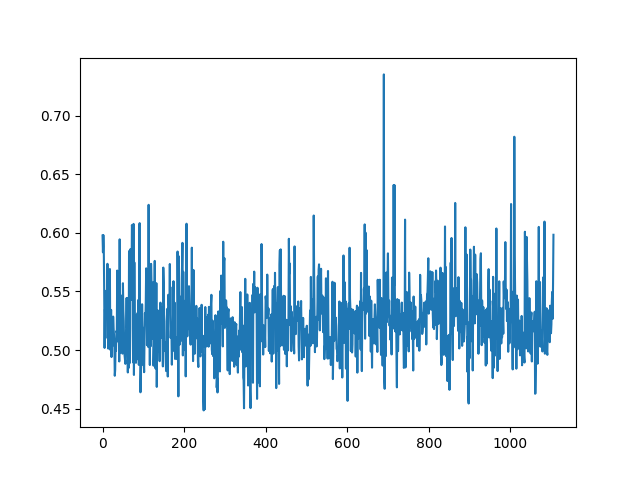

In [23]:
plt.plot()

In [24]:
plt.plot([x[6] for x in evaluation_data['a71e5cfb0a954f63b17c3c7b3c626e64']['data']])

# GenAI Scores

In [11]:
test = mlflow.metrics.genai.answer_correctness()
print(test.metric_details)


Task:
You must return the following fields in your response in two lines, one below the other:
score: Your numerical score for the model's answer_correctness based on the rubric
justification: Your reasoning about the model's answer_correctness score

You are an impartial judge. You will be given an input that was sent to a machine
learning model, and you will be given an output that the model produced. You
may also be given additional information that was used by the model to generate the output.

Your task is to determine a numerical score called answer_correctness based on the input and output.
A definition of answer_correctness and a grading rubric are provided below.
You must use the grading rubric to determine your score. You must also justify your score.

Examples could be included below for reference. Make sure to use them as references and to
understand them before completing the task.

Input:
{input}

Output:
{output}

{grading_context_columns}

Metric definition:
Answer cor

In [22]:
mlflow.deployments.set_deployments_target("http://localhost:5010")

similarity_metric = mlflow.metrics.genai.answer_similarity(
    model="endpoints:/chat"
)

In [54]:
run_data = (download_run_data(get_run_list([0])[0]))
run_data = pd.DataFrame(columns=run_data['columns'], data=run_data['data'])
run_data

,inputs,prompt_data,ground_truth,outputs,token_count,toxicity/v1/score,flesch_kincaid_grade_level/v1/score,ari_grade_level/v1/score,rougeL/v1/score
0,Liebe --- Die ''Liebe'' überwindet alle Grenzen.,"{'title': 'Liebe', 'context_word': 'Liebe', 'c...",inniges Gefühl der Zuneigung für jemanden oder...,starkes Gefühl der Zuneigung und Verbundenheit...,16,0.001495,6.8,16.9,0.400000
1,Liebe --- „Die ''Liebe'' ist in der Literatur ...,"{'title': 'Liebe', 'context_word': 'Liebe', 'c...",inniges Gefühl der Zuneigung für jemanden oder...,"tiefe Gefühlsregung, Hingezogenheit zu jemande...",22,0.005553,14.7,31.9,0.200000
2,Liebe --- „Im Mittelpunkt stand die ''Liebe''.“,"{'title': 'Liebe', 'context_word': 'Liebe', 'c...",inniges Gefühl der Zuneigung für jemanden oder...,tiefes Gefühl der Zuneigung und Verbundenheit....,16,0.001178,6.8,16.9,0.400000
3,"Liebe --- „Die Gefühle, die sie durchströmen u...","{'title': 'Liebe', 'context_word': 'Liebe', 'c...",inniges Gefühl der Zuneigung für jemanden oder...,intimes Gefühl tiefer Zuneigung für jemanden. ...,22,0.001057,6.4,17.9,0.521739
4,"Liebe --- „Erst zu Beginn der Fastenzeit, nach...","{'title': 'Liebe', 'context_word': 'Liebe', 'c...",inniges Gefühl der Zuneigung für jemanden oder...,tiefe Zuneigung im Sinne einer Beziehung</s>,14,0.001827,2.1,12.2,0.105263
...,...,...,...,...,...,...,...,...,...
1102,"Acht --- „Jetzt verhängt, wie Dr. Robert mitte...","{'title': 'Acht', 'context_word': 'Acht', 'con...",Ausschluss aus einer Gemeinschaft; Verurteilun...,Unterbindung von Zugang oder Handlung.</s>,12,0.002029,5.2,16.9,0.000000
1103,Acht --- „Seither tickt im ‚Runden Eck‘ eine Z...,"{'title': 'Acht', 'context_word': 'Acht', 'con...",Ausschluss aus einer Gemeinschaft; Verurteilun...,respektvoller Abstand oder Beachtung</s>,13,0.000999,9.6,24.1,0.000000
1104,"Acht --- „Der Kleine widerſtrebte, ſteif und u...","{'title': 'Acht', 'context_word': 'Acht', 'con...","Aufmerksamkeit, Beachtung; Fürsorge",Aufmerksamkeit; im Kontext bezieht sich dies a...,29,0.002729,8.0,14.3,0.100000
1105,Acht --- „Worüber ist das Buch: sagt Marie end...,"{'title': 'Acht', 'context_word': 'Acht', 'con...","Aufmerksamkeit, Beachtung; Fürsorge","Rücksicht, Sorgfalt, Aufmerksamkeit</ (Etwas, ...",32,0.036917,4.4,22.8,0.266667


In [42]:
print(similarity_metric.metric_details)


Task:
You must return the following fields in your response in two lines, one below the other:
score: Your numerical score for the model's answer_similarity based on the rubric
justification: Your reasoning about the model's answer_similarity score

You are an impartial judge. You will be given an input that was sent to a machine
learning model, and you will be given an output that the model produced. You
may also be given additional information that was used by the model to generate the output.

Your task is to determine a numerical score called answer_similarity based on the input and output.
A definition of answer_similarity and a grading rubric are provided below.
You must use the grading rubric to determine your score. You must also justify your score.

Examples could be included below for reference. Make sure to use them as references and to
understand them before completing the task.

Input:
{input}

Output:
{output}

{grading_context_columns}

Metric definition:
Answer similar

In [26]:
mlflow.set_experiment("SPIELWIESE")

with mlflow.start_run() as run:
    results = mlflow.evaluate(
        data=run_data,
        targets="ground_truth",
        predictions="outputs",
        extra_metrics=[similarity_metric],
        evaluators="default",
    )
    print(f"See aggregated evaluation results below: \n{results.metrics}")

    eval_table = results.tables["eval_results_table"]
    print(f"See evaluation table below: \n{eval_table}")

/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/mlflow/models/evaluation/base.py:521: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/mlflow/models/evaluation/base.py:521: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(_hash_array_like_element_as_bytes)
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in 

  0%|          | 0/1 [00:00<?, ?it/s]

/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jfeil/.pyenv/versions/3.10.12/envs/MasterThesis-NLP/lib/python3.10/site-packages/numpy/core/_methods.py:261: Runtime

  0%|          | 0/1107 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [55]:
responses = []

for index, row in tqdm(run_data.iterrows(), total=len(run_data)):
    result = similarity_prompt(row.ground_truth, row.outputs.replace("</s>", ""))
    responses += [result]

  0%|          | 0/1107 [00:00<?, ?it/s]

In [63]:
from collections import defaultdict

sum = 0
levels = defaultdict(lambda: 0)

for i, judge in responses:
    sum += i
    levels[i] += 1
    if i == 2:
        print(judge)
sum/1107

Die Ausgabe "kurz für Geschlechtsteil" passt nicht zum Kontext der zusätzlichen Informationen, die das Modell verwendet hat, die darauf hinweisen, dass "Geschlecht" in diesem Fall die Größe oder das Ausmaß beziehen sollte. Die Ausgabe stimmt nur teilweise mit dem Ziel überein, da sie das Wort "Geschlecht" verwendet, das in diesem Kontext irreführend ist.
Die Ausgabe des Modells "ah, aha" deutet auf eine esoterische Interpretation hin, indem sie die erste Verwendung des Buchstabens "A" im Alphabet erwähnt. Dies ist nicht direkt mit der Zielvorgabe verbunden, die sich auf das erste Buchstaben des Alphabets im Kontext eines Buches oder eines Wortes bezieht. Die Zielvorgabe erwartet eine präzisere und kontextbezogene Antwort, die das erste Auftreten des Buchstabens "A" in der angegebenen Phrase oder im Kontext des Ziels erklärt. Daher weist die Ausgabe der Modell nur eine teilweise semantische Ähnlichkeit mit dem Ziel auf.
Die Ausgabe "Penis" reflektiert nur minimal den Kontext der vorgege

3.299006323396567

In [61]:
levels

defaultdict(<function __main__.<lambda>()>, {4: 319, 3: 770, 5: 10, 2: 8})

In [71]:
similarity_prompt(row.prompt_data['context_sentence'], row.prompt_data['context_word'], row.ground_truth, row.outputs.replace("</s>", ""))

' \nPunktzahl: 4\nBegründung: Die bereitgestellte Ausgabe stimmt in den meisten Aspekten mit den vorgegebenen Zielen überein und weist eine große semantische Ähnlichkeit auf. Sie erfasst das Gefühl der Zuneigung und Verbundenheit und die Bedeutung von "finniges Gefühl der Zuneigung für jemanden oder für etwas". Die Ausgabe enthält auch die notwendigen Details und den Kontext, die in der Zielvorgabe enthalten sind. Daher weist sie eine hohe semantische Ähnlichkeit auf.assistant\n\nPunktzahl: 4\nBegründung: Die bereitgestellte Ausgabe stimmt in den meisten Aspekten mit den vorgegebenen Zielen überein und weist eine große semantische Ähnlichkeit auf. Sie erfasst das Gefühl der'

In [58]:
responses

[(4,
  'Die bereitgestellte Ausgabe "inniges Gefühl der Zuneigung für jemanden oder für etwas" entspricht in den meisten wesentlichen Aspekten den vorgegebenen Zielen "fstarkes Gefühl der Zuneigung und Verbundenheit". Sie erfasst die grundlegende Bedeutung von Zuneigung und Verbundenheit und weist eine große semantische Ähnlichkeit mit den vorgegebenen Zielen auf, obwohl sie nicht spezifisch auf "stark" oder "Verbundenheit" eingeht.'),
 (4,
  'Die bereitgestellte Ausgabe "inniges Gefühl der Zuneigung für jemanden oder für etwas" entspricht dem Ziel "ftiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas." zwar nicht in allen Details, aber in den meisten wesentlichen Aspekten. Sie fängt den Kern der Zielvorgabe – eine tiefgehende emotionale Bindung oder Zuneigung – ein und weist eine große semantische Ähnlichkeit mit dem Ziel auf.'),
 (4,
  'Die bereitgestellte Ausgabe "inniges Gefühl der Zuneigung für jemanden oder für etwas" entspricht dem Ziel "ftiefes Gefühl der Zuneigung und Verbun

In [43]:
print(similarity_prompt("inniges Gefühl der Zuneigung für jemanden oder für etwas", "tiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas."))

(4, 'Die bereitgestellte Ausgabe "inniges Gefühl der Zuneigung für jemanden oder für etwas" entspricht dem Ziel "ftiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas." zwar nicht in allen Details, aber in den meisten wesentlichen Aspekten. Sie fängt den Kern der Zielvorgabe – eine tiefgehende emotionale Bindung oder Zuneigung – ein und weist eine große semantische Ähnlichkeit mit dem Ziel auf.')


In [44]:
print(similarity_prompt("inniges Gefühl der Zuneigung für jemanden oder für etwas", "starkes Gefühl der Zuneigung und Verbundenheit</s>"))

(4, 'Die bereitgestellte Ausgabe "inniges Gefühl der Zuneigung für jemanden oder für etwas" entspricht dem Ziel "fstarkes Gefühl der Zuneigung und Verbundenheit" in seinem Ganzen und weist eine große semantische Ähnlichkeit auf, da sie das Konzept der Zuneigung und Verbundenheit auf ein allgemeineres Niveau erweitert. Sie erfasst die grundlegende Bedeutung des Ziels und verwendet ähnliche Wortbedeutungen, obwohl sie nicht spezifisch auf "für jemanden oder für etwas" eingeht, wie es im Ziel vorgeschrieben ist.')


In [45]:
print(similarity_prompt("inniges Gefühl der Zuneigung für jemanden oder für etwas", "starkes Gefühl der Zuneigung und Verbundenheit"))

(4, 'Die bereitgestellte Ausgabe "inniges Gefühl der Zuneigung für jemanden oder für etwas" entspricht in den meisten wesentlichen Aspekten den vorgegebenen Zielen "fstarkes Gefühl der Zuneigung und Verbundenheit". Sie erfasst die grundlegende Bedeutung von Zuneigung und Verbundenheit und weist eine große semantische Ähnlichkeit mit den vorgegebenen Zielen auf, obwohl sie nicht spezifisch auf "stark" oder "Verbundenheit" eingeht.')


In [50]:
print(similarity_prompt("inniges Gefühl der Zuneigung für jemanden oder für etwas", "tiefes Gefühl der Zuneigung und Verbundenheit."))

(-1, '')


In [52]:
print(similarity_prompt("Rekrut",
                        "Schreibgerät.", debug=True))



(-1, '')


# Evaluation

In [14]:
runs = get_run_list([0, 1])

means = {run_id: {} for run_id in runs}

for run in runs:
    for i in range(0, 3):
        run_data = download_run_data(run, f"genai_wizardlm3_{i}.json")
        if run_data is None:
            continue
        means[run][i] = np.array([int(x[-2]) for x in run_data['data']])

In [9]:
run_data['data'][1]

["Liebe --- „Die ''Liebe'' ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“",
 {'title': 'Liebe',
  'context_word': 'Liebe',
  'context_sentence': '„Die Liebe ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“'},
 'inniges Gefühl der Zuneigung für jemanden oder für etwas',
 'tiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas.</s>',
 3,
 "Die Ausgabe des Modells 'tiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas.' entspricht in den meisten Aspekten den vorgegebenen Zielen 'inniges Gefühl der Zuneigung für jemanden oder für etwas'. Die Ausgabe des Modells fängt den emotionalen Aspekt und die Hingezogenheit an, die in den Zielen beschrieben sind. Allerdings ist die spezifische Formulierung im Ziel 'inniges Gefühl der Zuneigung für jemanden oder für etwas' etwas präziser als die Formulierung der Ausgabe. Daher weist die Ausgabe eine große semantische Ähnlichkei

In [12]:
download_run_data(run, f"genai_wizardlm3_{1}.json")['data'][1]

["Liebe --- „Die ''Liebe'' ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“",
 {'title': 'Liebe',
  'context_word': 'Liebe',
  'context_sentence': '„Die Liebe ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“'},
 'inniges Gefühl der Zuneigung für jemanden oder für etwas',
 'tiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas.</s>',
 3,
 "Die Ausgabe des Modells 'tiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas.' entspricht in den meisten Aspekten den vorgegebenen Zielen 'inniges Gefühl der Zuneigung für jemanden oder für etwas'. Die Ausgabe des Modells fängt den emotionalen Aspekt und die Hingezogenheit an, die in den Zielen beschrieben sind. Allerdings ist die spezifische Formulierung im Ziel 'inniges Gefühl der Zuneigung für jemanden oder für etwas' etwas präziser als die Formulierung der Ausgabe. Daher weist die Ausgabe eine große semantische Ähnlichkei

In [13]:
download_run_data(run, f"genai_wizardlm3_{0}.json")['data'][1]


["Liebe --- „Die ''Liebe'' ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“",
 {'title': 'Liebe',
  'context_word': 'Liebe',
  'context_sentence': '„Die Liebe ist in der Literatur ausreichend dargestellt worden, ihren Schilderungen kann nichts Neues hinzugefügt werden.“'},
 'inniges Gefühl der Zuneigung für jemanden oder für etwas',
 'tiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas.</s>',
 3,
 "Die Ausgabe des Modells 'tiefe Gefühlsregung, Hingezogenheit zu jemandem/etwas.' entspricht in den meisten Aspekten den vorgegebenen Zielen 'inniges Gefühl der Zuneigung für jemanden oder für etwas'. Die Ausgabe des Modells fängt den emotionalen Aspekt und die Hingezogenheit an, die in den Zielen beschrieben sind. Allerdings ist die spezifische Formulierung im Ziel 'inniges Gefühl der Zuneigung für jemanden oder für etwas' etwas präziser als die Formulierung der Ausgabe. Daher weist die Ausgabe eine große semantische Ähnlichkei

In [15]:
for run in means:
    print(run)
    for column in means[run]:
        print(np.mean(means[run][column], axis=0))

a71e5cfb0a954f63b17c3c7b3c626e64
3.168021680216802
4.401084010840108
71254e7e5ced4ce2a27c5de31f7fb7ab
3.1571815718157183
4.373080397470641
e1d3f1f8aace43caa693e9836834504e
3.158988256549232
4.3983739837398375
cb8135f768dd4a8285257deb0bc3d912
3.169828364950316
4.37940379403794
5565790ff7c74ef69997fc0af6a3cd06
3.1662149954832883
4.384823848238482
41ef3452981a4b208aa35c8f8b7197df
3.4218608852755192
4.57542908762421
14ae3307f7df4c26b249b847ef24c26a
3.682926829268293
4.585365853658536
ebee22c9aef14c8baaca0ec3192e8833
3.335140018066847
4.567299006323396
9eaf7a3028bd4b2cb773d0105f165add
3.187895212285456
4.4137308039747065
7e5d6c8cba4d49a8853e5e4c06072da7
3.176151761517615
4.430894308943089
2bd01c54631c41c48ece315af304a7c0
3.091237579042457
4.220415537488708
6819089ff044491b97e144e4e1c111ff
3.076784101174345
4.220415537488708
e24c349c5d314b4c935bf351e256f480
3.034327009936766
4.4561878952122855
6bf2254afdc2439ebd8f566ab84b5b82
3.2330623306233064
4.60252935862692
6e16e2ab19f240188837143a053cb2

In [8]:
run_data['data'][4][4]

3